In [18]:
##########################################################################
#                         IMPORTING PACKAGES
##########################################################################

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob, os

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model , Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from imgaug import augmenters as iaa

In [19]:
def extract_label(img_path):
    filename, _ = os.path.splitext(os.path.basename(img_path))
    
    user_id, etc = filename.split('__')
    gender, left_right, finger = etc.split('_')[:3]
    
    gender = 0 if gender == 'M' else 1
    left_right = 0 if left_right =='Left' else 1
    
    if finger == 'thumb':
        finger = 0
    elif finger == 'index':
        finger = 1
    elif finger == 'middle':
        finger = 2
    elif finger == 'ring':
        finger = 3
    elif finger == 'little':
        finger = 4
        
    return np.array([user_id, gender, left_right , finger], dtype=np.uint16)

In [21]:
img_type = {'real' : 'SOCOFing/Real/*.BMP' ,
            'easy' : 'SOCOFing/Altered/Altered-Easy/*.BMP' ,
            'medium' : 'SOCOFing/Altered/Altered-Medium/*.BMP',
            'hard' : 'SOCOFing/Altered/Altered-Hard/*.BMP' }

for Type , Loc in img_type.items():
    img_list = sorted(glob.glob(Loc))
    print(Type , " : " ,len(img_list))

    imgs = np.empty((len(img_list), 90, 90), dtype=np.uint8)
    labels = np.empty((len(img_list), 4), dtype=np.uint16)

    for i, img_path in enumerate(img_list):
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        img = cv.resize(img, (90, 90))
        imgs[i] = img

        # subject_id, gender, lr, finger
        labels[i] = extract_label(img_path)

    globals()["x_"+ Type] = imgs[ ..., np.newaxis]
    globals()["y_"+ Type] = labels

real  :  6000
easy  :  17931
medium  :  17067
hard  :  14272


In [22]:
print(x_real.shape, y_real.shape)

(6000, 90, 90, 1) (6000, 4)


In [23]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(49270, 90, 90, 1) (49270, 4)
(44343, 90, 90, 1) (44343, 4)
(4927, 90, 90, 1) (4927, 4)


In [24]:
label_real_dict = {}
for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)
    label_real_dict[key] = i


In [13]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [14]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

In [19]:
inputs = layers.Input(shape=(90, 90, 1))

# define feature model
feature_model = Sequential()
feature_model.add(layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(90, 90, 1)))
feature_model.add(layers.MaxPooling2D(pool_size=2))
feature_model.add(layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'))
feature_model.add(layers.MaxPooling2D(pool_size=2))
feature_model.add(layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'))
feature_model.add(layers.MaxPooling2D(pool_size=2))
feature_model.add(layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'))
feature_model.add(layers.MaxPooling2D(pool_size=2))

# create inputs and get features
x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

# define classification model
classification_model = Sequential()
classification_model.add(layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'))
classification_model.add(layers.MaxPooling2D(pool_size=2))
classification_model.add(layers.Flatten())
classification_model.add(layers.Dense(32, activation='relu'))
classification_model.add(layers.Dense(32, activation='relu'))
classification_model.add(layers.Dense(16, activation='relu'))
classification_model.add(layers.Dense(1, activation='sigmoid'))

# create final model
model = Model(inputs=[x1, x2], outputs=classification_model(net))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 5, 5, 32)     28064       ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 subtract_2 (Subtract)          (None, 5, 5, 32)     0           ['sequential_2[0][0]',     

In [18]:
x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

# share weights both inputs
inputs = layers.Input(shape=(90, 90, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(32, activation='relu')(net)

net = layers.Dense(16, activation='relu')(net)

net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 model_1 (Functional)           (None, 5, 5, 32)     28064       ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 subtract_1 (Subtract)          (None, 5, 5, 32)     0           ['model_1[0][0]',          

In [43]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
model.fit(train_gen, epochs=30, validation_data=val_gen , callbacks = [early_stop])

Epoch 1/30
1385/1385 [==============================] - 30s 22ms/step - loss: 0.1713 - acc: 0.9334 - val_loss: 0.0495 - val_acc: 0.9910
Epoch 2/30
1385/1385 [==============================] - 32s 23ms/step - loss: 0.1026 - acc: 0.9614 - val_loss: 0.0392 - val_acc: 0.9926
Epoch 3/30
1385/1385 [==============================] - 32s 23ms/step - loss: 0.0773 - acc: 0.9724 - val_loss: 0.0400 - val_acc: 0.9879
Epoch 4/30
1385/1385 [==============================] - 31s 22ms/step - loss: 0.0676 - acc: 0.9765 - val_loss: 0.0304 - val_acc: 0.9931
Epoch 5/30
1385/1385 [==============================] - 38s 27ms/step - loss: 0.0639 - acc: 0.9773 - val_loss: 0.0203 - val_acc: 0.9949
Epoch 6/30
1385/1385 [==============================] - 36s 26ms/step - loss: 0.0574 - acc: 0.9793 - val_loss: 0.0329 - val_acc: 0.9896
Epoch 7/30
1385/1385 [==============================] - 31s 22ms/step - loss: 0.0485 - acc: 0.9829 - val_loss: 0.0135 - val_acc: 0.9978
Epoch 8/30
1385/1385 [==========================

In [46]:
losses = pd.DataFrame(model.history.history)

<Axes: >

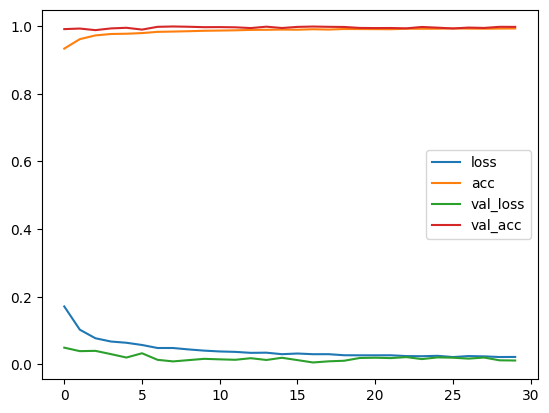

In [47]:
losses.plot()

In [18]:
model.save('model.h5')

In [15]:
def fingerprint_Matcher(fingerprint1, fingerprint2):
    # Load the pre-trained model and real data
    
#     model = load_model('model.h5')
    try:
        model = load_model('model.h5')
    except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
        print("call the model here")
    
    
    fingerprint1 = cv.imread(fingerprint1, cv.IMREAD_GRAYSCALE)
    fingerprint2 = cv.imread(fingerprint2, cv.IMREAD_GRAYSCALE)
    fingerprint1 = cv.resize(fingerprint1, (90, 90))
    fingerprint2 = cv.resize(fingerprint2, (90, 90))

    # Convert input fingerprints to appropriate format
    fingerprint1 = fingerprint1.reshape((1, 90, 90, 1)).astype(np.float32) / 255.
    fingerprint2 = fingerprint2.reshape((1, 90, 90, 1)).astype(np.float32) / 255.
    
    # Predict the match score for fingerprint1 {real} with fingerprint2 {comparison one}
    # model accecpt comparison one vs real
    pred_score = model.predict([fingerprint2, fingerprint1])
    
    # Determine if the fingerprints match based on the score
    is_match = (pred_score >= 0.5)
    
    # prepare output image
    match_image = np.concatenate((fingerprint1.squeeze(), fingerprint2.squeeze()), axis=1)

    # set title of image as comparison score
    title = 'Score: %.02f' % pred_score
    match_image = plt.imshow(match_image, cmap='gray')
    match_image.axes.set_title(title)

    # Return the match score, boolean result, and match image
    return pred_score, is_match, match_image


In [16]:
fingerprint_Matcher('SOCOFing/Real/150__M_Right_index_finger.BMP','SOCOFing/Altered/Altered-Hard/150__M_Right_index_finger_Obl.BMP')

call training model here


UnboundLocalError: local variable 'model' referenced before assignment

1/1 [==============================] - 0s 80ms/step


(array([[0.0033048]], dtype=float32),
 array([[False]]),
 <matplotlib.image.AxesImage at 0x1962dde2ee0>)

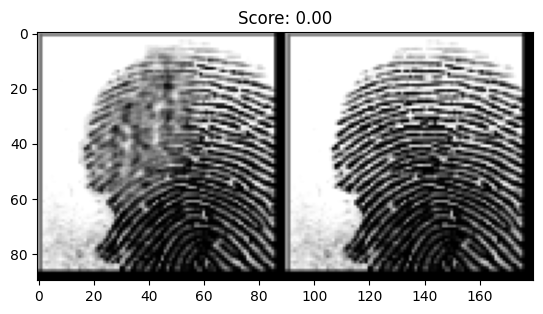

In [44]:
fingerprint_Matcher('SOCOFing/Altered/Altered-Hard/150__M_Right_index_finger_Obl.BMP','SOCOFing/Real/150__M_Right_index_finger.BMP')